# 讀取檔案

In [26]:
import numpy as np
import pandas as pd

In [27]:
# 如果有遇到編碼問題加入encoding="unicode_escape"可以解決

df_train_x = pd.read_csv("1905_TrainX.csv", index_col = "UID")
df_train_y = pd.read_csv("1906_TrainY.csv", index_col = "UID")

In [28]:
# 預測資料

df_test_x = pd.read_csv("1906_TestX.csv", index_col = "UID")
df_test_y = pd.read_csv("1907_TestY.csv", index_col = "UID")

# 看資料型態及狀態

In [29]:
df_train_x.shape

(1138, 14)

In [30]:
df_train_x.dtypes

FirstVIPKind                object
VIPGetTime                   int64
LastLogDate                  int64
TotalPay                     int64
TotalPay_-2                  int64
TotalPay_-1                  int64
TotalPay_All                 int64
LastPayDate                float64
LastLogDate-LastPayDate    float64
PayTotalCount_N              int64
PayTotalCount_-2             int64
PayTotalCount_-1             int64
PayTotalCount_All            int64
ARPPU                      float64
dtype: object

In [31]:
df_test_x.dtypes

FirstVIPKind                object
VIPGetTime                   int64
LastLogDate                  int64
TotalPay                     int64
TotalPay_-2                  int64
TotalPay_-1                  int64
TotalPay_All                 int64
LastPayDate                float64
LastLogDate-LastPayDate    float64
PayTotalCount_N              int64
PayTotalCount_-2             int64
PayTotalCount_-1             int64
PayTotalCount_All            int64
ARPPU                      float64
dtype: object

# 資料前處理

In [32]:
#轉類別型態

mapping = {'PayDay_10000': 1,
           'PayMonth_30000': 2,
           'PayStack_50000': 3,
           'OtherGameVIP': 4,
          }
df_train_x['FirstVIPKind'] = df_train_x['FirstVIPKind'].map(mapping)

In [33]:
# 預測資料轉類別型態

mapping = {'PayDay_10000': 1,
           'PayMonth_30000': 2,
           'PayStack_50000': 3,
           'OtherGameVIP': 4,
          }
df_test_x['FirstVIPKind'] = df_train_x['FirstVIPKind'].map(mapping)

In [34]:
# 設定欄位為 datatime 格式

# df_train_x['VIPGetTime'] = pd.to_datetime(df_train_x['VIPGetTime'])
# df_train_x['LastLogDate'] = pd.to_datetime(df_train_x['LastLogDate'])
# df_train_x['LastPayDate'] = pd.to_datetime(df_train_x['LastPayDate'])

# Xgboost (可類別可數值)

In [35]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [36]:
y = df_train_y

x1, x2, y1, y2 = train_test_split(df_train_x, y, test_size=0.3, random_state=99) #隨機切割資料集和測試集
dtrain = xgb.DMatrix(x1, y1) #DMatrix格式的數據為XGBoost二進制格式，可提高運行速度
dvalid = xgb.DMatrix(x2, y2) 

In [37]:
#xg_reg = xgb.XGBRegressor( 
# learning_rate =0.07,
# n_estimators=1400,
# max_depth=8,
# min_child_weight=1,
# gamma=0.1,
# subsample=0.6,
# reg_alpha= 2,
# reg_lambda= 1,
# colsample_bytree=0.9,
# nthread=4,
# scale_pos_weight=1,
# seed=0)

In [38]:
params = {'eta': 0.07, #學習率，可控制過擬合
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 3, #樹的深度
          'subsample': 0.7, #採取Y樣本比例，可預防過擬合
          'colsample_bytree': 0.7, #採取特徵樣本比例
          'lambda': 8, #L2懲罰項目，越大越不容易過擬合
          'colsample_bylevel':0.7, #採取子節點樣本比例
          'min_child_weight':0, #子節點的樣子權重合，可以調整擬合
          'objective': 'binary:logistic', #採用二元分類羅吉斯，輸出為機率 
          'scale_pos_weight':99,
          'eval_metric': 'auc', #檢查預測結果
          'nthread':10, #線程數
          'random_state': 99, 
          'silent': True}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 250, watchlist, maximize=True, early_stopping_rounds = 30, verbose_eval=5)

[03:57:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	train-auc:0.75043	valid-auc:0.713436
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[5]	train-auc:0.82668	valid-auc:0.779356
[10]	train-auc:0.887193	valid-auc:0.875438
[15]	train-auc:0.887944	valid-auc:0.868967
[20]	train-auc:0.890021	valid-auc:0.872282
[25]	train-auc:0.893993	valid-auc:0.864618
[30]	train-auc:0.900428	valid-auc:0.869178
[35]	train-auc:0.906337	valid-auc:0.872142
[40]	train-auc:0.912589	valid-auc:0.877087
[45]	train-auc:0.917253	valid-auc:0.878525
[50]	train-auc:0.918053	valid-auc:0.884347
[55]	train-auc:0.920781	valid-auc:0.894238
[60]	train-auc:0.925092	valid-auc:0.899446
[65]	train-auc:0.928365	valid-auc:0.900884
[70]	train-auc:0.929946	valid-auc:0.904391
[75]	train-auc:0.932667	valid-auc:0.903444
[80]	train-auc:0.934646	valid-auc:0.907109
[85]	train-auc:0.937361	valid-au

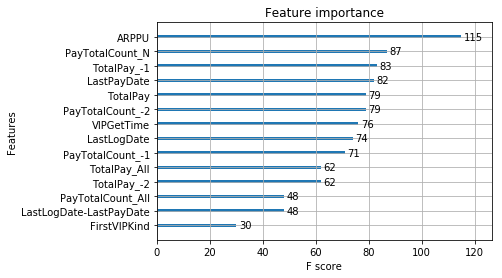

In [39]:
#畫出模型相關係數圖

ax = xgb.plot_importance(model, max_num_features=300)
# plt.savefig('test%d.png'%(fileno), dpi=600,bbox_inches="tight")
plt.show()

In [40]:
#再看一次狀態確認是否可以比對

df_train_x.shape
#df_test_x.shape

(1138, 14)

In [41]:
#把真實值裝入Sub中

sub = pd.DataFrame()
sub['SurvivalStatus'] = df_test_y['SurvivalStatus'].astype('int')

In [43]:
dtest = xgb.DMatrix(df_test_x)

# Save the predictionsA
sub['SurvivalStatus'] = model.predict(dtest, ntree_limit=model.best_ntree_limit) #模型預測出來也裝進真實值
sub.to_csv('Xgb_Test001.csv', float_format='%.8f', index=False) #存檔並保存多少為小數點

PermissionError: [Errno 13] Permission denied: 'Xgb_Test001.csv'

In [44]:
df_test_y

,SurvivalStatus
UID,
6800559,1
6800586,1
6800803,1
6802198,1
6803108,1
6803682,1
6804635,1
6804645,0
6805333,0


In [45]:
#拿真實答案和預測答案做比對

from sklearn.metrics import roc_auc_score
roc_auc_score(df_test_y, sub)

0.9032021151586369

# 隨機森林

In [25]:
df_train_x = df_train_x.fillna(0)

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(criterion='entropy',n_estimators=10,random_state=3,n_jobs=2)
forest.fit(df_train_x, df_train_y)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [27]:
df_test_x = df_test_x.fillna(0)

In [29]:
predict=forest.predict(df_test_x)
from sklearn import metrics
print(metrics.classification_report(df_test_y, predict,target_names=['target 0', 'target 1']))

              precision    recall  f1-score   support

    target 0       0.00      0.00      0.00       715
    target 1       0.41      0.84      0.55       595

   micro avg       0.38      0.38      0.38      1310
   macro avg       0.21      0.42      0.28      1310
weighted avg       0.19      0.38      0.25      1310



# LightGbm (只能數值) (先不用)

In [ ]:
df_train_x.head(3)

In [ ]:
#df_train_x.drop(['FirstVIPKind'], axis=1, inplace=True)
#df_test_x.drop(['FirstVIPKind'], axis=1, inplace=True)
df_train_x.drop(['VIPGetTime'], axis=1, inplace=True)
df_test_x.drop(['VIPGetTime'], axis=1, inplace=True)

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train = lgb.Dataset(df_train_x, df_train_y)
valid = lgb.Dataset(df_test_x, df_test_y, reference=train)

In [ ]:
ytest=df_test_y.astype('int')
# 導入到lightgbm矩陣
lgb_train = lgb.Dataset(df_train_x,df_train_y)
lgb_test = lgb.Dataset(df_test_x, df_test_y, reference=lgb_train)

# 設置參數
params = {
    'num_leaves': 100,
    'num_trees':2000,
    'metric': ('auc', 'logloss'),#可以設置多個評價指標
   # 'verbose': 0,
    'max_depth': 1000,
    'learning_rate': 0.05,
     #'feature_fraction': 0.7,
     #'bagging_fraction': 0.8,
    'objective':'binary'
    
}
# if (evals_result and gbm) not in locbals():
    # global evals_result,gbm 
#如果是局部變量的話，推薦把他們變成全局變量，這樣plot的代碼位置不受限制
evals_result = {}  #記錄訓練結果所用

print('開始訓練...')
# train

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,#非常重要的參數,一定要明確設置
                verbose_eval=100)

print('畫出訓練結果...')
ax = lgb.plot_metric(evals_result, metric='auc')#metric的值與之前的params裏面的值對應
plt.show()

print('畫特徵重要性排序...')
ax = lgb.plot_importance(gbm, max_num_features=150)#max_features表示最多展示出前10個重要性特徵，可以自行設置
plt.show()

from sklearn import metrics
predict=gbm.predict(df_test_x)
#判斷1或0
predict=pd.DataFrame(predict)[0].apply(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(df_test_y,predict,target_names=['target 0', 'target 1']))

In [ ]:
#準確率

from sklearn.metrics import accuracy_score
accuracy_score(df_test_y, predict) # Return the number of correctly classified samples

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_test_y, predict)